# Age Estimation and Gender Classification

In this assignment, you will train CNN models to estimate a person's age and gender by given a face image. Please read carefully all the instructions before you start to write your code.

**Your tasks**

You need train two CNN models:
- one is defined by you with a few restrictions and be trained from scratch, save it as `age_gender_A.h5`
- the other is to finetune a pretrained model, save it as `age_gender_B.h5`

**Dataset**

Your models will be trained and validated on a folder `train_val/` containing 5,000 labeled face images (size: 128 x 128), originated from the UTKFace dataset. During marking, your code will be tested on unseen test data. 

**Performance metric**

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Absolute Error)
- gender classification: accuracy

**Please use the GPU time wisely.**

Just be aware that there is some limit of free GPU usage (It is said the users can use up to 12 hours in row. But many people found they reached its limit far less than 12 hours.). Therefore, I would give you three suggestions to mimimise the risk of reaching the limit.

1. Make sure you have a stable internet connection.
2. Double check all the hyperparameters are good before you start to train the model.
3. According to my experience, each model should be trained in less than 2 hours. If much longer than that, you'd better consider adjusting the architecture.

## Setting Up: Mount the google drive
Mount your google drive to the notebook. 

Also don't forget to **enable GPU** before your training.


In [119]:
# Load the Drive helper and mount
from google.colab import drive
# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Visualize a few photos
It is always benificial to know your data well before you start. Here display a few (at least 20) images together with its corresponding age and gender from the `train_val/` folder to have a first impression of the dataset. You may also check what the size of the images are.

In [120]:
# Use cv2 and os libraries to import images and print image information
import cv2
import os
import matplotlib.pyplot as plt

dir = '/content/drive/My Drive/'
path = dir + 'train_val/'
num_of_examples = len(os.listdir(path))
print(f'Number of images: {num_of_examples}.')
print(f'Test image name: {os.listdir(path)[0]}')
print(f'Test image dimensions: {cv2.imread(os.path.join(path, os.listdir(path)[0])).shape}') 


# Display 20 Images
for img_name in os.listdir(path)[0:20]:
  img = cv2.imread(os.path.join(path, img_name))   # get image as array from full path and name
  img_cvt=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)     # colour image appropriately 
   # Extract image information (age, gender)
  img_name = img_name.split('_')
  if img_name[1] == '0':
    img_name[1] = 'Male'
  else: 
    img_name[1] = 'Female'
 
  # Plot images
  '''
  plt.title(f'Age: {img_name[0]}, Gender: {img_name[1]}')
  plt.imshow(img_cvt)
  plt.show()
  '''

Number of images: 5000.
Test image name: 40_0_3_20170119183403621.jpg.chip.jpg
Test image dimensions: (128, 128, 3)


## Rearrange the dataset
You may do any arrangement for the dataset to suit your later process, such as splitting into training set and validation set, saving the gender labels and age some how, and so on.


In [121]:
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

df = pd.DataFrame(columns=['filename','age','gender','race'])

for filename in os.listdir(path):
  age, gender, race, time = filename.split('_')
  df.loc[len(df.index)] = [filename, float(age), float(gender), float(race)]

df_train, df_val = train_test_split(df, test_size=0.2, random_state=1, shuffle=True)
print(f'Train Images: {len(df_train)}, Validation Images: {len(df_val)}')

Train Images: 4000, Validation Images: 1000


## STEP1: Data pre-processing
Now you need do some pre-processing before feeding data into a CNN network. You may consider:

1.	Rescale the pixel values (integers between 0 and 255) to [0,1]. **You must do this rescaling.** Otherwise the testing performance will be affected significantly, as the test images will be rescaling in this way. 
2.	Data augmentation.

**Don't rescale the age to [0,1].** Otherwise the testing performance will be affected significantly, as the original age is used in the testing stage. 

In [122]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    width_shift_range = 0.2,
    height_shift_range = 0.2,

    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest',
    )

test_datagen = ImageDataGenerator(
    rescale = 1./255, 
    )

batch_size = 32
labels = ['age', 'gender']

train_generator = train_datagen.flow_from_dataframe(
    dataframe = df_train,
    directory = path,
    target_size = (128, 128),
    batch_size = batch_size,
    class_mode = 'multi_output',
    x_col = 'filename',
    y_col = labels,
    shuffle = False,
    )

validation_generator = test_datagen.flow_from_dataframe(
    dataframe = df_val,
    directory = path,
    target_size = (128, 128),
    batch_size = batch_size,
    class_mode = 'multi_output',
    x_col = 'filename',
    y_col = labels,
    shuffle = False,
    )

'''
test_generator = test_datagen.flow_from_dataframe(
    dataframe = df_test,
    directory = path,
    target_size = (128, 128),
    batch_size = batch_size,
    class_mode = None,
    x_col = 'filename',
    y_col = None
)
'''

num_of_batches_train = len(train_generator)
num_of_batches_val = len(validation_generator)

Found 4000 validated image filenames.
Found 1000 validated image filenames.


## STEP2A: Build your own CNN network
Define your own CNN for classifying the gender and predicting the age. Though there are two tasks, you need **only one CNN model, but with two outputs** - you may search online for solution.

There are a few restrictions about your network as follows.
1.	The input size must be 128 x 128 x 3, which means you **should not resize** the original images. This is because my test code relies on this particular input size. Any other size will cause problem in the testing stage.
2.  Please treat the gender classification as a binary problem, i.e., **the output layer for the gender branch has only 1 unit**, instead of 2 (though it is correct to treat the gender classification as a mutli-class problem where class number is 2, the last layer has 2 units). This is because my test code only works for the 1-unit-last-layer gender branch setting. 
3.	The size of feature maps being fed to the first fully connected layer must be less than 10 x 10, while there is no number limitation about the depth.
4.	You may choose any techniques for preventing overfitting. 

In the end of the cell, use `modelA.summary()` to output the model architecture. You may also use `plot_model()` to visualize its architecture.

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 126, 126, 32  896         ['input_10[0][0]']               
                                )                                                                 
                                                                                                  
 max_pooling2d_12 (MaxPooling2D  (None, 63, 63, 32)  0           ['conv2d_12[0][0]']              
 )                                                                                          

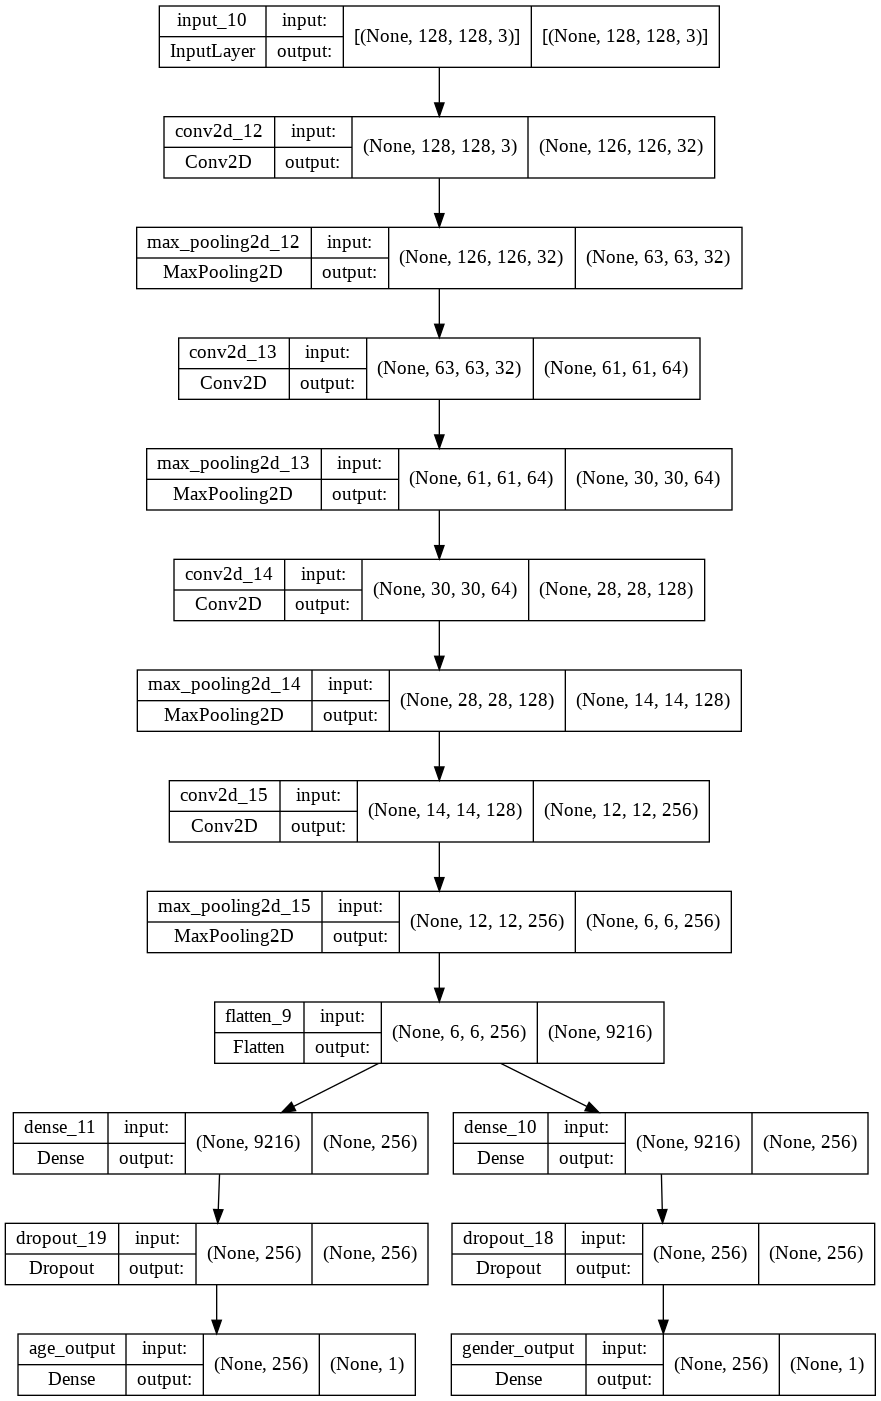

In [123]:
import tensorflow as tf
from keras.models import Sequential, Model, load_model

from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

input_shape = (128,128,3)

inputs = Input((input_shape))

conv = Conv2D(32, kernel_size=(3,3), activation='relu')(inputs)
maxpool = MaxPooling2D(pool_size=(2,2))(conv)
conv = Conv2D(64, kernel_size=(3,3), activation='relu')(maxpool)
maxpool = MaxPooling2D(pool_size=(2,2))(conv)
conv = Conv2D(128, kernel_size=(3,3), activation='relu')(maxpool)
maxpool = MaxPooling2D(pool_size=(2,2))(conv)
conv = Conv2D(256, kernel_size=(3,3), activation='relu')(maxpool)
maxpool = MaxPooling2D(pool_size=(2,2))(conv)

flatten = Flatten()(maxpool)

dense_1 = Dense(256, activation='relu')(flatten)
dense_2 = Dense(256, activation='relu')(flatten)

dropout_1 = Dropout(0.3)(dense_1)
dropout_2 = Dropout(0.3)(dense_2)

gender_output = Dense(1, activation='sigmoid', name='gender_output')(dropout_1)
age_output = Dense(1, activation='linear', name='age_output')(dropout_2)

modelA = Model(inputs=inputs, outputs=[age_output, gender_output])

modelA.summary()
from tensorflow.keras.utils import plot_model
plot_model(modelA, show_shapes=True)

## STEP3A: Compile and train your model
Compile and train your model here. 
Save your model by `modelA.save(your_model_folder+"age_gender_A.h5")` after training. 

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Save the model with `save()` instead of `save_weights()`.** This is because I will load the model by 

`modelA = load_model(model_folder+"age_gender_A.h5")`. 


In [124]:
# Compile model
modelA.compile(optimizer='adam', loss={'age_output': 'mse', 'gender_output': 'binary_crossentropy'}, 
               metrics={'age_output': 'mae', 'gender_output': 'accuracy'}, 
               loss_weights={'age_output': 0.01, 'gender_output': 0.99})

# Epochs
EPOCHS = 100

# Fit model to data
history = modelA.fit(train_generator, epochs=EPOCHS, validation_data=validation_generator, batch_size=32)

# Save the model
#model_folder = '/content/drive/MyDrive/'
#modelA.save(model_folder+'age_gender_A.h5')

Epoch 1/100
125/125 [==============================] - 67s 175ms/step - loss: 5.6767 - age_output_loss: 494.9481 - gender_output_loss: 0.7346 - age_output_mae: 17.1307 - gender_output_accuracy: 0.5242 - val_loss: 4.7385 - val_age_output_loss: 405.6630 - val_gender_output_loss: 0.6888 - val_age_output_mae: 15.3029 - val_gender_output_accuracy: 0.5280
Epoch 2/100
125/125 [==============================] - 21s 165ms/step - loss: 4.8713 - age_output_loss: 418.5542 - gender_output_loss: 0.6926 - age_output_mae: 15.6767 - gender_output_accuracy: 0.5185 - val_loss: 4.9735 - val_age_output_loss: 429.0275 - val_gender_output_loss: 0.6902 - val_age_output_mae: 17.1259 - val_gender_output_accuracy: 0.5830
Epoch 3/100
125/125 [==============================] - 20s 164ms/step - loss: 4.6903 - age_output_loss: 400.3875 - gender_output_loss: 0.6934 - age_output_mae: 15.3503 - gender_output_accuracy: 0.5042 - val_loss: 4.6263 - val_age_output_loss: 394.0307 - val_gender_output_loss: 0.6930 - val_age_o

In [125]:
# Load the model
model_folder = '/content/drive/MyDrive/'
modelA = load_model(model_folder+"age_gender_A.h5")

## STEP4A: Draw the learning curves
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set


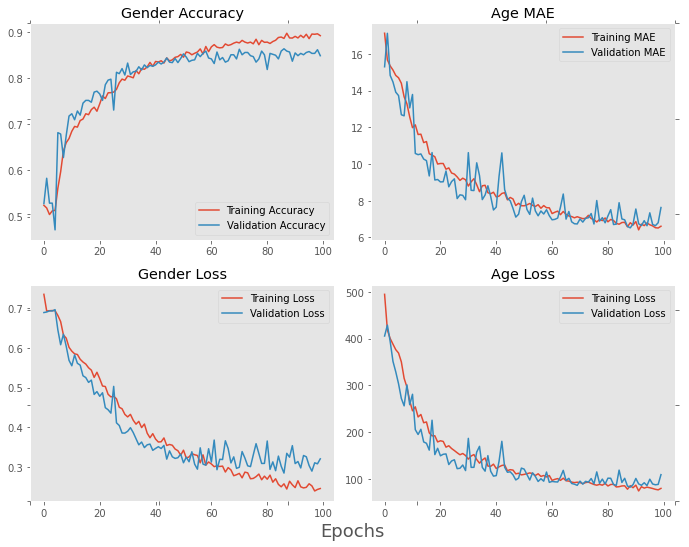

In [126]:
def model_complexity_graph(history):
    
    '''
    Plots model complexity graph to determine how many epochs you need (i.e. when the model starts overfitting the data)
    
    '''

    import matplotlib.pyplot as plt
    
    training_accuracy_gender = history.history['gender_output_accuracy']
    validation_accuracy_gender = history.history['val_gender_output_accuracy']
    training_loss_gender = history.history['gender_output_loss']
    validation_loss_gender = history.history['val_gender_output_loss']

    training_mae_age = history.history['age_output_mae']
    validation_mae_age = history.history['val_age_output_mae']
    training_loss_age = history.history['age_output_loss']
    validation_loss_age = history.history['val_age_output_loss']

    epochs_range=range(len(training_accuracy_gender))

    with plt.style.context('ggplot'):
      plt.rcParams['axes.grid'] = False
      fig, axs = plt.subplots(2, 2, figsize=(10, 8), tight_layout=True)

      axs[0, 0].plot(epochs_range, training_accuracy_gender, label='Training Accuracy')
      axs[0, 0].plot(epochs_range, validation_accuracy_gender, label='Validation Accuracy')
      axs[0, 0].set_title('Gender Accuracy')
      axs[0, 0].legend()

      axs[1, 0].plot(epochs_range, training_loss_gender, label='Training Loss')
      axs[1, 0].plot(epochs_range, validation_loss_gender, label='Validation Loss')
      axs[1, 0].set_title('Gender Loss')
      axs[1, 0].legend()


      axs[0, 1].plot(epochs_range, training_mae_age, label='Training MAE')
      axs[0, 1].plot(epochs_range, validation_mae_age, label='Validation MAE')
      axs[0, 1].set_title('Age MAE')
      axs[0, 1].legend()


      axs[1, 1].plot(epochs_range, training_loss_age, label='Training Loss')
      axs[1, 1].plot(epochs_range, validation_loss_age, label='Validation Loss')
      axs[1, 1].set_title('Age Loss')
      axs[1, 1].legend()

      ax = plt.gcf().add_subplot(111, frameon=False)
      ax.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
      ax.set_xlabel('Epochs', fontsize=18)

model_complexity_graph(history)

## STEP5A: Prediction with Test Data
Predict the age and gender of a single image input and determine the performance of the trained model on a test dataset.

In [127]:
df_test = pd.DataFrame(columns=['filename','age','gender'])

path = dir+'crop_part1/'

for filename in os.listdir(path):
  age, gender = filename.split('_')[:2]
  df_test.loc[len(df_test.index)] = [filename, float(age), float(gender)]

df_test = df_test[(df_test['gender'] == 1) | (df_test['gender'] == 0)]

df_test, _ = train_test_split(df_test, test_size=0.80, random_state=1, shuffle=True, stratify=df_test['gender'])

test_generator = test_datagen.flow_from_dataframe(
  dataframe = df_test,
  directory = path,
  target_size = (128, 128),
  batch_size = batch_size,
  class_mode = 'multi_output',
  x_col = 'filename',
  y_col = labels,
  shuffle = False,
  validate_filenames = False
)

print(f'Test Images: {len(df_test)}')

Found 1959 non-validated image filenames.
Test Images: 1959


In [128]:
def predict(df_test, image_number=0, batch_size=1):

  path = dir+'crop_part1/'
  
  test_generator = test_datagen.flow_from_dataframe(
    dataframe = df_test,
    directory = path,
    target_size = (128, 128),
    batch_size = batch_size,
    class_mode = 'multi_output',
    x_col = 'filename',
    y_col = labels,
    shuffle = False,
    validate_filenames = False
  )

  true_age = round(df_test['age'].iloc[image_number])
  true_gender = round(df_test['gender'].iloc[image_number])

  predictions = modelA.predict(test_generator)
  pred_age = round(predictions[0][image_number][0])
  pred_gender = round(predictions[1][image_number][0])

  img = cv2.imread(os.path.join(path, df_test['filename'].iloc[image_number]))
  img_cvt=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  print(f'Actual Age: {true_age}, Actual Gender: {true_gender}')
  print(f'Predicted Age: {pred_age}, Predicted Gender: {pred_gender}')
  plt.imshow(img_cvt)


Found 1959 non-validated image filenames.
Actual Age: 26, Actual Gender: 1
Predicted Age: 25, Predicted Gender: 1


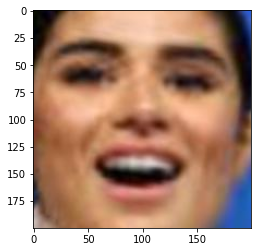

In [129]:
predict(df_test, image_number=1, batch_size=1)

62/62 [==============================] - 4s 64ms/step
Gender Accuracy: 0.8356304236855538
Age MAE: 6.769270035732516



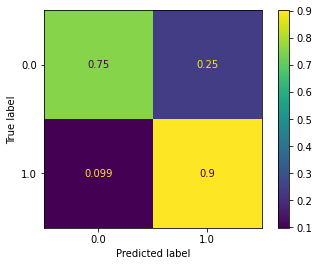

In [130]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, mean_absolute_error

predictions = modelA.predict(test_generator, verbose=1)

pred_age = predictions[0].round()
pred_gender = predictions[1].round()

true_age = df_test['age'].round()
true_gender = df_test['gender'].round()

print(f'Gender Accuracy: {accuracy_score(true_gender, pred_gender)}')
print(f'Age MAE: {mean_absolute_error(true_age, pred_age)}')
print('')
ConfusionMatrixDisplay.from_predictions(true_gender, pred_gender, normalize='true')
plt.show()

## STEP2B: Build a CNN network based on a pre-trained model 
Choose one existing CNN architecture pre-trained on ImageNet, and fine-tune on this dataset.

The same as required in Model A, **don’t resize the input image size**. **The output layer for the gender branch is set to have only 1 unit**. 

In the end of the cell, use `modelB.summary()` to output the model architecture. You may also use `plot_model()` to visualize its architecture.


In [131]:
from keras.applications.resnet import ResNet50

model_ResNet50 = ResNet50(weights = 'imagenet',
                  include_top = False,
                  input_shape = (128,128,3))

modelB = model_ResNet50
#modelB.summary()

## STEP3B: Compile and train your model
Compile and train your model here. 
Save your model to `age_gender_B.h5` after training. 

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Also, save the model with `save()` instead of `save_weights()`.** 


In [132]:
from tensorflow.keras.optimizers import Adam

input_shape = [128, 128, 3]

inputB = tf.keras.Input(shape=input_shape)
inputB2 = model_ResNet50(inputB)

age_outputB = model_ResNet50(inputB)
age_outputB = tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu')(inputB2)
age_outputB = tf.keras.layers.Dropout(0.3)(age_outputB)
age_outputB = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(age_outputB)

age_outputB = tf.keras.layers.Flatten()(age_outputB)
age_outputB = tf.keras.layers.Dense(128, activation='relu')(age_outputB)
age_outputB = tf.keras.layers.Dropout(0.3)(age_outputB)
age_outputB = tf.keras.layers.Dense(1, activation = 'linear', name='age_output')(age_outputB)


gender_outputB = model_ResNet50(inputB)
gender_outputB = tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu')(inputB2)
gender_outputB = tf.keras.layers.Dropout(0.3)(gender_outputB)
gender_outputB = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(gender_outputB)

gender_outputB = tf.keras.layers.Flatten()(gender_outputB)
gender_outputB = tf.keras.layers.Dense(128, activation='relu')(gender_outputB)
gender_outputB = tf.keras.layers.Dropout(0.3)(gender_outputB)
gender_outputB = tf.keras.layers.Dense(1, activation = 'sigmoid', name='gender_output')(gender_outputB)

modelB = tf.keras.Model(
    inputs=inputB,
    outputs=[age_outputB, gender_outputB]
)

epochs = 50
init_lr = 1e-4

opt = Adam(learning_rate=init_lr, decay=init_lr/epochs)

# Compile model
modelB.compile(optimizer=opt, loss={'age_output': 'mse', 'gender_output': 'binary_crossentropy'}, 
               metrics={ 'age_output': 'mae', 'gender_output': 'accuracy'},
               loss_weights={'age_output': 0.01, 'gender_output': 0.99})

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=111, min_delta = 0.001)
save_best = tf.keras.callbacks.ModelCheckpoint('./model_recent.h5', monitor='loss', save_best_only=True)

# Epochs
EPOCHS = 50

# Fit model to data
history = modelB.fit(train_generator, epochs=EPOCHS, callbacks=[early_stopping, save_best], validation_data=validation_generator, verbose=1)

modelB.save(model_folder+"age_gender_B.h5")

Epoch 1/50
125/125 [==============================] - 35s 225ms/step - loss: 3.6643 - age_output_loss: 305.3716 - gender_output_loss: 0.6168 - age_output_mae: 12.9380 - gender_output_accuracy: 0.7028 - val_loss: 9.0735 - val_age_output_loss: 839.3770 - val_gender_output_loss: 0.6866 - val_age_output_mae: 23.5504 - val_gender_output_accuracy: 0.6170
Epoch 2/50
125/125 [==============================] - 28s 222ms/step - loss: 2.0865 - age_output_loss: 165.9698 - gender_output_loss: 0.4311 - age_output_mae: 9.5552 - gender_output_accuracy: 0.8030 - val_loss: 7.8092 - val_age_output_loss: 709.8616 - val_gender_output_loss: 0.7178 - val_age_output_mae: 21.2505 - val_gender_output_accuracy: 0.4700
Epoch 3/50
125/125 [==============================] - 27s 215ms/step - loss: 1.7678 - age_output_loss: 140.3985 - gender_output_loss: 0.3675 - age_output_mae: 8.7400 - gender_output_accuracy: 0.8360 - val_loss: 6.0911 - val_age_output_loss: 529.3293 - val_gender_output_loss: 0.8058 - val_age_output

In [133]:
# Load the model
model_folder = '/content/drive/MyDrive/'
modelB = load_model(model_folder+"age_gender_B.h5")

## STEP4B: Draw the learning curve
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set

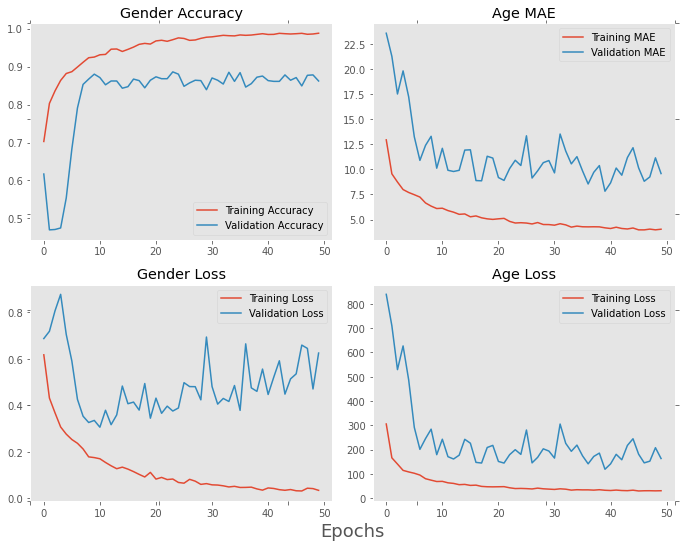

In [135]:
model_complexity_graph(history)

## STEP5A: Prediction with Test Data
Determine the performance of the trained model on a test dataset.

62/62 [==============================] - 5s 69ms/step
Gender Accuracy: 0.852475752935171
Age MAE: 8.790199081163859



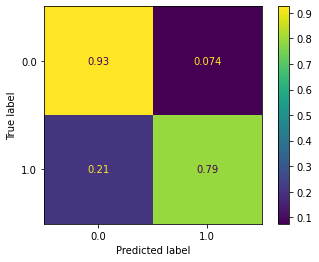

In [134]:
predictions = modelB.predict(test_generator, verbose=1)

pred_age = predictions[0].round()
pred_gender = predictions[1].round()

true_age = df_test['age'].round()
true_gender = df_test['gender'].round()

print(f'Gender Accuracy: {accuracy_score(true_gender, pred_gender)}')
print(f'Age MAE: {mean_absolute_error(true_age, pred_age)}')
print('')
ConfusionMatrixDisplay.from_predictions(true_gender, pred_gender, normalize='true')
plt.show()